# **3D Bounding Boxes from LiDAR Point Cloud Data**

In this tutorial we will learn how to draw 3D bounding boxes on detected objects. The high level pipeline will be:
- In the camera images, detect objects in 2D 
- Project LiDAR Depth information on the object 
- Get 3D location of object in image/camera space
- Draw 3D bounding box


Once again, the KITTI dataset is located [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Let's donwload the data, I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified, which is very important for this excercise

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-30 00:56:17--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.61
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  26.1MB/s    in 36s     

2022-08-30 00:56:54 (25.0 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-30 00:56:54--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.81
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-30 00:56:55 (203 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [3]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [4]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [5]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [6]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 227
Number of right images: 227
Number of LiDAR point clouds: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [7]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [8]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [9]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

The rectified Rotation matrices will be used to help transform a LiDAR point to the camera frame of reference.

#### **Get LiDAR to Camera Rotation and Translation Matrices**

In [10]:
with open(r'2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

The LiDAR to Camer translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space

$$ y = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} x,
  \qquad \text{where } x = [x, y, z, 1]^T $$
NOTE:  x is the 3D point in homogeneous coordinates.

Since we will be using the left image we will go ahead and make a function to rotate a single LiDAR poin to the left image.

### **Create LiDAR points pipeline**

We will read in the LiDAR point clouds and transform them to the image plane. The code is partially based on the this [repository](https://github.com/azureology/kitti-velo2cam). Once again the information for the calibration parameters is located [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

In [183]:
def get_velo2cam(lidar_bin):
    ''' Converts the LiDAR point cloud to left camera (u, v, z) image 
        coordinates, where z is in meters
        '''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # convert to homogeneous coordinate system
    velo_points = scan_data[:, 0:3] # (x, y, z) --> (front, left, up)
    velo_points = np.insert(velo_points, 3, 1, axis=1).T # homogeneous LiDAR points

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1) 

    # possibly use RANSAC to remove the ground plane for better viewing?

    # convert to (left) camera coordinates
    velo_camera = P_left @ R_left_rect @ T_cam_velo @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    return velo_camera

In [12]:
def project_velo2cam(lidar_bin, image):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get camera (u, v, z) coordinates
    velo_camera = get_velo2cam(lidar_bin)

    (u, v, z) = velo_camera

    # remove outliers (points outside of the image frame)
    img_h, img_w, _ = image.shape
    u_out = np.logical_or(u < 0, u > img_w)
    v_out = np.logical_or(v < 0, v > img_h)
    outlier = np.logical_or(u_out, v_out)
    velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)
    
    return velo_camera

In [13]:
index = 220

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

(u, v, z) = project_velo2cam(lidar_bin, left_image)

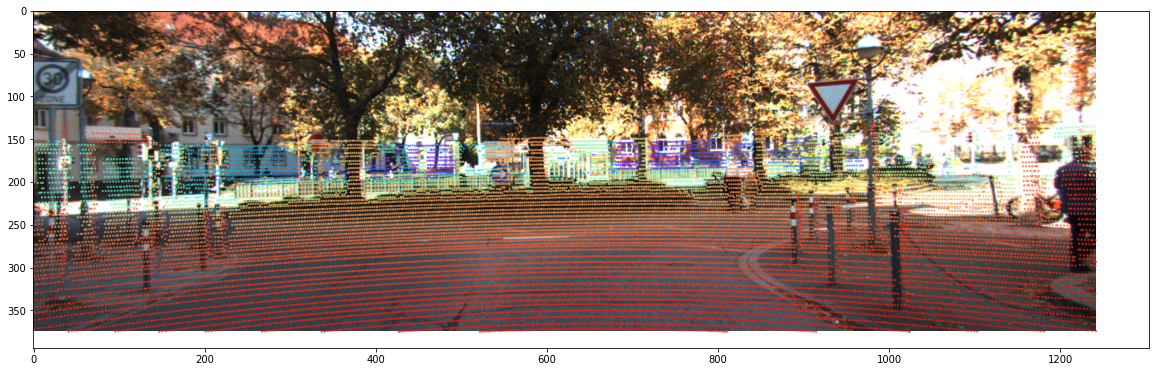

In [14]:
# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

## **Get Object Detection Pipeline**

Just like part 1, we will use yolov5

In [15]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12123, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 12123 (delta 37), reused 35 (delta 18), pack-reused 12047
Receiving objects: 100% (12123/12123), 12.57 MiB | 25.33 MiB/s, done.
Resolving deltas: 100% (8325/8325), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [17]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-8-30 Python-3.7.13 torch-1.12.1+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [18]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [50]:
def get_distances(image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                       - np.array([[x_center, y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([v[min_loc], u[min_loc], velo_depth])

        # OR just get velo (u, v, z) rotated to image/camera space and add to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int), 
                             np.round(x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return image, bboxes_out

In [54]:
def get_depth_detections(left_image, lidar_bin, draw_boxes=True, 
                         draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    ## 1. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get distance measurements for image
    left_image, bboxes_out = get_distances(left_image, 
                                                          velo_camera, 
                                                          bboxes, 
                                                          draw=draw_depth)

    return left_image, bboxes_out, velo_camera

## **Test the base pipeline**

In [55]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

left_image, bboxes_out, velo_camera = get_depth_detections(left_image, 
                                                           lidar_bin, 
                                                           draw_boxes=True, 
                                                           draw_depth=True)

In [60]:
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_camera, velo_image, color_map=get_color):
   
    # unpack LiDAR points
    u, v, z = velo_camera

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(velo_image, (int(u[i]), int(v[i])), 1, 
                  color_map(z[i]), -1);

    return velo_image


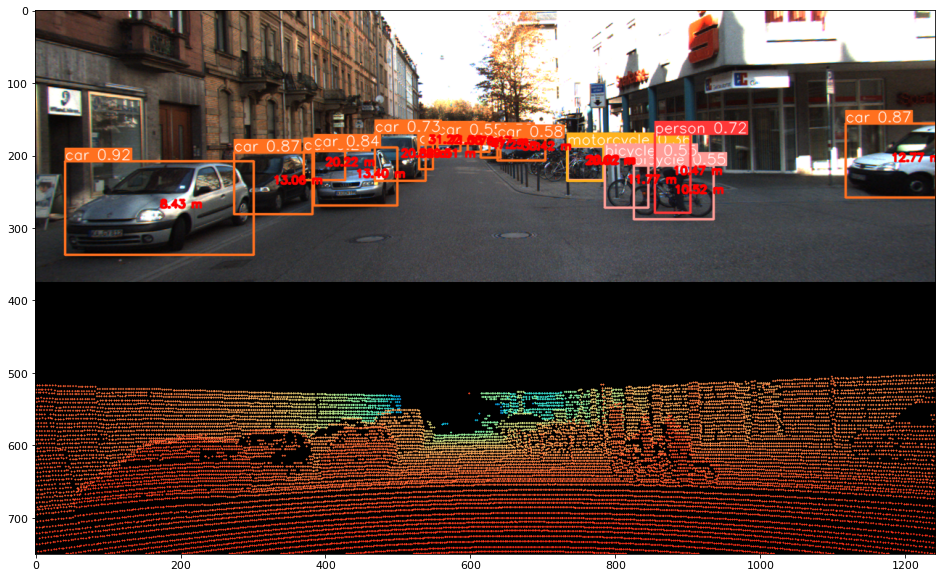

In [61]:
velo_image = np.zeros_like(left_image)
velo_image = draw_velo_on_image(velo_camera, velo_image)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

In [62]:
bboxes_out

array([[     41.952,      208.31,      301.98,      337.09,       0.923,           2,      273.22,      170.92,      8.4331],
       [     1117.5,      156.73,        1242,      258.48,     0.86962,           2,      204.98,      1180.8,      12.768],
       [     274.72,      196.44,       382.2,      281.78,     0.86701,           2,      235.58,      329.19,      13.057],
       [     384.43,      189.91,      499.16,      269.61,       0.836,           2,      231.49,      442.15,      13.397],
       [     468.99,      169.73,      538.64,      235.41,      0.7307,           2,      203.47,      503.98,      20.855],
       [     854.05,      171.29,      903.68,      279.84,     0.71825,           0,      227.42,      877.66,      10.472],
       [     637.94,      176.15,      703.85,      207.86,     0.58247,           2,      194.93,      671.39,      33.416],
       [     554.88,      173.74,      586.53,      194.15,     0.55197,           2,      195.92,      568.22,      7

## **Lets move on to extracting 3D point cloud objects**

First we need to run the RANSAC algorithm to remove the plane. But we will need to use the points the LiDAR frame of reference, so we need a way of contiunously relating the image point cloud with the True LiDAR point cloud

In [119]:
velo_camera

array([[     502.88,      500.57,      498.25, ...,      629.05,      626.65,      624.27],
       [     157.13,      157.09,      157.05, ...,      371.67,      371.69,      371.66],
       [     76.759,      75.002,      73.352, ...,       6.068,       6.076,      6.0781]])

In [174]:
from sklearn import linear_model

ransac = linear_model.RANSACRegressor(
                                      linear_model.LinearRegression()
                                     )

X = np.vstack((velo_camera[0, :], velo_camera[2, :])).T
y = velo_camera[1, :].T
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression())

In [175]:
mask = ransac.inlier_mask_

# unpack LiDAR points
u, v, z = velo_camera[:, mask]

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
               get_color(z[i]), -1);

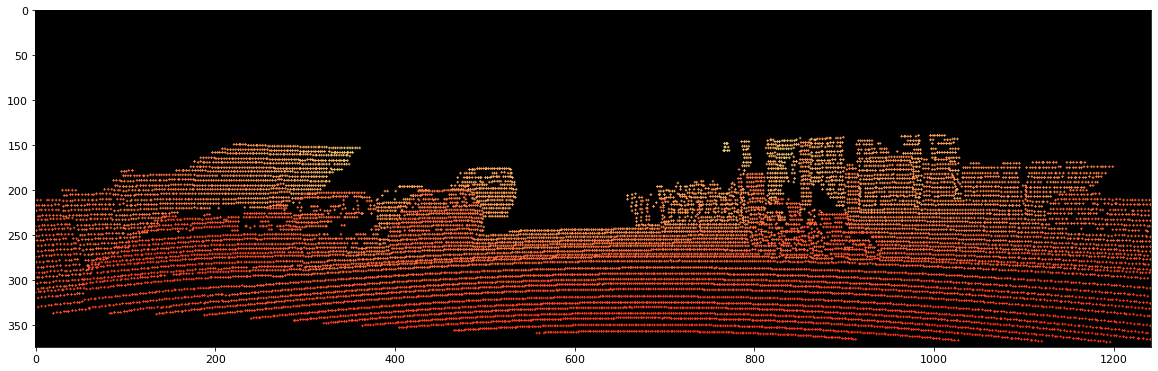

In [176]:
plt.imshow(new_image);

Read points directly from bin file and use RANSAC to remove the ground plane

In [254]:
scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

# convert to homogeneous coordinate system
velo_points = scan_data[:, 0:3] # (x, y, z) --> (front, left, up)

In [255]:
velo_points

array([[     76.942,      11.739,       2.841],
       [     75.186,      11.712,       2.782],
       [     73.536,      11.691,       2.727],
       ...,
       [     14.955,      -2.981,      -6.995],
       [     15.038,      -2.973,      -7.032],
       [     15.174,      -2.951,      -7.092]], dtype=float32)

In [327]:
from sklearn import linear_model

ransac = linear_model.RANSACRegressor(
                                      linear_model.LinearRegression(),
                                      residual_threshold=0.1,
                                      max_trials=5000
                                     )

X = velo_points[:, :2]
y = velo_points[:, -1]
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), max_trials=5000,
                residual_threshold=0.1)

In [328]:
# remove outlier points
mask = ransac.inlier_mask_
masked_velo_points = velo_points[~mask]

In [329]:
# convert to camera frame of reference
masked_velo_points = np.insert(masked_velo_points, 3, 1, axis=1).T # homogeneous LiDAR points

# delete negative liDAR points
masked_velo_points = np.delete(masked_velo_points, np.where(masked_velo_points[3, :] < 0), axis=1) 

# possibly use RANSAC to remove the ground plane for better viewing?

# convert to (left) camera coordinates
masked_velo_camera = P_left @ R_left_rect @ T_cam_velo @ masked_velo_points

# delete negative camera points ??
masked_velo_camera  = np.delete(masked_velo_camera , np.where(masked_velo_camera [2,:] < 0)[0], axis=1) 

# get camera coordinates u,v,z
masked_velo_camera[:2] /= masked_velo_camera[2, :]

In [330]:
# remove outliers (points outside of the image frame)
u, v, z = masked_velo_camera
img_h, img_w, _ = left_image.shape
u_out = np.logical_or(u < 0, u > img_w)
v_out = np.logical_or(v < 0, v > img_h)
outlier = np.logical_or(u_out, v_out)
masked_velo_camera = np.delete(masked_velo_camera, np.where(outlier), axis=1)

In [331]:
masked_velo_camera

array([[     502.88,      500.57,      498.25, ...,      114.09,      110.71,      107.36],
       [     157.13,      157.09,      157.05, ...,      333.14,      333.53,      334.07],
       [     76.759,      75.002,      73.352, ...,      8.1506,      8.1417,      8.2399]])

In [332]:
# unpack LiDAR points
u, v, z = masked_velo_camera

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
               get_color(z[i]), -1);

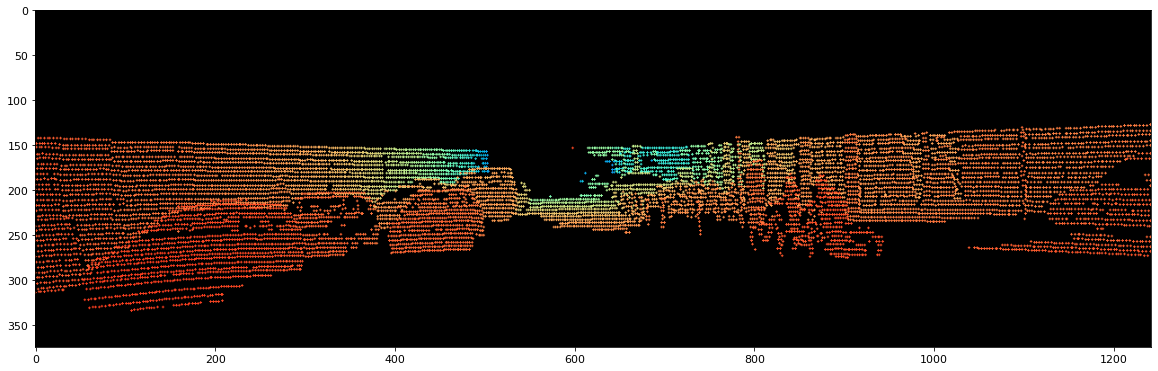

In [333]:
plt.imshow(new_image);

consider the first object with bbox_out of:
[     41.952,      208.31,      301.98,      337.09,       0.923,           2,      273.22,      170.92,      8.4331]


In [334]:
u_locs = (masked_velo_camera[0, :] >= 40) & (masked_velo_camera[0, :] <= 310)
v_locs = (masked_velo_camera[1, :] >= 200) & (masked_velo_camera[1, :] <= 340)

In [337]:
obj1_velo_camera = masked_velo_camera[:, u_locs & v_locs]
obj1_velo_camera.shape

(3, 1912)

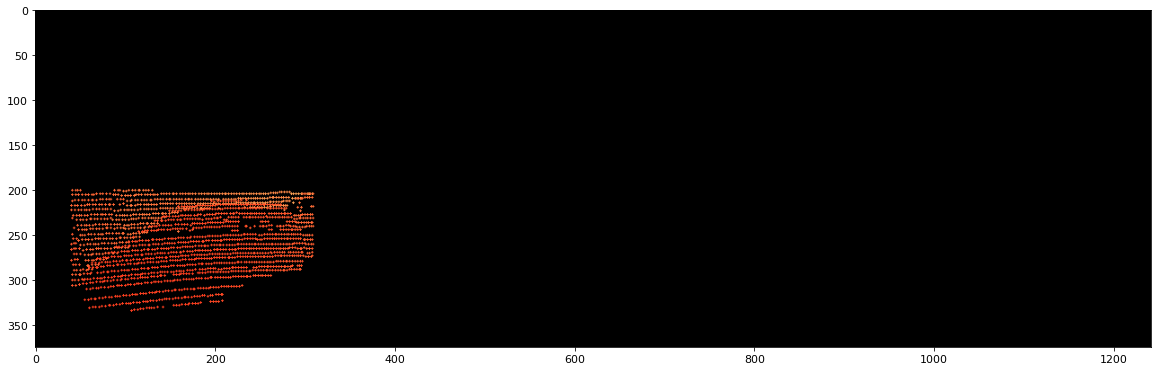

In [338]:
new_image = np.zeros_like(left_image)
new_image = draw_velo_on_image(obj1_velo_camera, new_image)

plt.imshow(new_image);

In [339]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=5, min_samples=5)

model.fit(obj1_velo_camera.T)

DBSCAN(eps=5)

In [340]:
np.unique(model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [148]:
obj1_velo_camera[1, :].shape

(2217,)

In [149]:
pastel = cm.get_cmap('hsv')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
               get_pastel(labels[i]), -1);

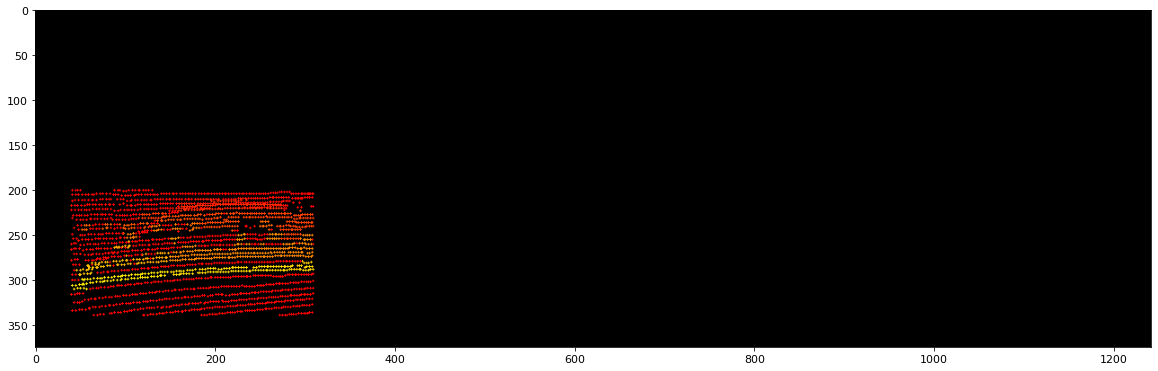

In [150]:
plt.imshow(new_image);

## **Now make a full pipeline**
This pipeline will input a stereo pair along with a LiDAR point cloud. It will compute stereo depth and log error info

## **Now let's run the depth check on another sample of KITTI data!**

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-08-28 18:56:13--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.92
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  10.8MB/s    in 4m 36s  

2022-08-28 19:00:50 (10.7 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-08-28 19:00:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-28 19:00:52 (58.0 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [ ]:
!jar xf 2011_10_03_calib.zip

### Get the Calibration data

In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [ ]:
with open(r'2011_10_03/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

In [ ]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837


## **Now let's make a video**

In [ ]:
error_metrics = []
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                                left_image, 
                                                                right_image, 
                                                                lidar_bin, 
                                                                draw_boxes=True, 
                                                                method='median')
    
    # draw LiDAR point cloud on new blank image
    u, v, z = velo_camera
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    for i in range(len(u)):
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_color(z[i]), -1);
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)

    # ensure that errors were recorded
    if len(errors) > 0:
        error_metrics.append(errors)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

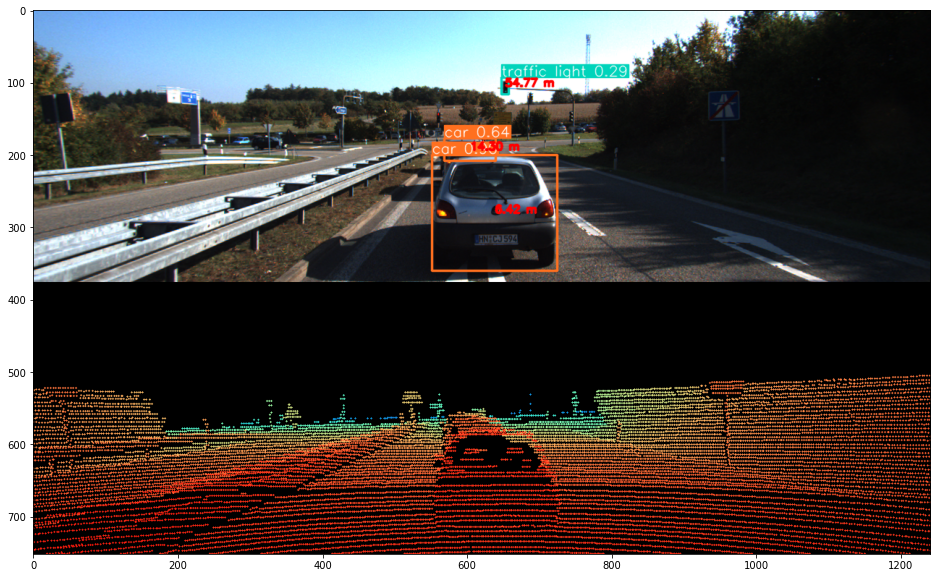

In [ ]:
plt.imshow(stacked);